# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [81]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
print('...Test Data...')
print(testset)
print(f'number of batches in the testloader: {len(testloader)}') #157batches of 10000 images, each batch has 64 images, the image in the loader are shuffled 
print ('...Train Data...')
print(trainset)
print(f'number of batches in the trainloader: {len(trainloader)}') #938batches of 60000 images, each batch has 64 images, the image in the loader are shuffled 

...Test Data...
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:\Users\152703/.pytorch/F_MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
number of batches in the testloader: 157
...Train Data...
Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: C:\Users\152703/.pytorch/F_MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
number of batches in the trainloader: 938


Here I'll create a model like normal, using the same one from my solution for part 4.

In [82]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1) 
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [83]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)
print(ps)

torch.Size([64, 10])
tensor([[0.1063, 0.0901, 0.0891, 0.1043, 0.0948, 0.0979, 0.1162, 0.0996, 0.0958,
         0.1060],
        [0.1045, 0.0890, 0.0901, 0.1023, 0.0974, 0.0985, 0.1129, 0.1025, 0.0996,
         0.1031],
        [0.1034, 0.0901, 0.0900, 0.1034, 0.0974, 0.0984, 0.1135, 0.1024, 0.0951,
         0.1065],
        [0.1043, 0.0900, 0.0897, 0.1052, 0.0954, 0.0969, 0.1150, 0.1014, 0.0968,
         0.1054],
        [0.1035, 0.0886, 0.0903, 0.1082, 0.0951, 0.0988, 0.1151, 0.1008, 0.0966,
         0.1030],
        [0.1023, 0.0876, 0.0880, 0.1068, 0.0954, 0.0981, 0.1164, 0.1026, 0.0970,
         0.1058],
        [0.1037, 0.0891, 0.0895, 0.1051, 0.0961, 0.0968, 0.1149, 0.1017, 0.0972,
         0.1060],
        [0.1068, 0.0890, 0.0903, 0.1051, 0.0960, 0.0971, 0.1122, 0.1025, 0.0996,
         0.1014],
        [0.1050, 0.0900, 0.0906, 0.1032, 0.0961, 0.0954, 0.1148, 0.1007, 0.0987,
         0.1056],
        [0.1039, 0.0883, 0.0901, 0.1048, 0.0983, 0.0980, 0.1134, 0.1015, 0.0985,
       

With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [84]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples

print(top_class[:10,:10])
print(top_p[:10,:])


tensor([[6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6]])
tensor([[0.1162],
        [0.1129],
        [0.1135],
        [0.1150],
        [0.1151],
        [0.1164],
        [0.1149],
        [0.1122],
        [0.1148],
        [0.1134]], grad_fn=<SliceBackward>)


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [85]:
equals = top_class == labels.view(*top_class.shape)      
print(equals.shape)
print(equals.type)

torch.Size([64, 1])
<built-in method type of Tensor object at 0x0000014CE8B48090>


Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [86]:
accuracy = torch.mean(equals.type(torch.FloatTensor))                                                                                                                                                                                                                                                                                                                                                                           
print(f'Accuracy: {accuracy*100}%')

Accuracy: 12.5%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [88]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses, accuracy = [], [],[] #initiate the place holder for train_losses and test_losses for all 30 epochs => each list will have 30 items
for e in range(epochs): #iter through each epoch
    running_loss = 0
    for images, labels in trainloader: #iter through each batch of trainloader, 64 images were test
        
        optimizer.zero_grad() #clear the gradients before the start of each batch as gradients accumulate
        
        log_ps = model(images) #feedforward 64 images through the model
        loss = criterion(log_ps, labels) #Caculate the loss for this batch of images
        loss.backward() #backpropagate the loss through the network
        optimizer.step() #use gradient descent to update the weight
         
        running_loss += loss.item()  #caculate the total loss of the batch 
        
    else: #after the model was trained through entire train set in 1 epoch, we applied that model to the test set
        ## TODO: Implement the validation pass and print out the validation accuracy
        running_test_loss = 0 #reset test_loss and accuracy score for the next epoch
        running_Accuracy = 0 
        for images, labels in testloader: #iterate through each batch of the testset
            with torch.no_grad():
                output = model.forward(images) #iterate images in the batch through the trained model 
                test_loss = criterion(output, labels) #Calculate test loss for the batch
                ps = torch.exp(output) #get class probability for output
                top_p,top_class = ps.topk(1,dim=1)
                equals = top_class == labels.view(*top_class.shape) #binary tensor of (0,1) for 64 images in the batch
                #Calculate accuracy score for the batch: sum(equals)/(#imagesinbatch)
                Accuracy = torch.mean(equals.type(torch.FloatTensor)) 
                
            running_test_loss += test_loss.item() #total test loss of all batches in 1 epoch
            running_Accuracy += Accuracy.item() #total accuracy of all batches in 1 epoch
        print("Epoch:{}".format(e))
        print("Training loss:{:.3f}..".format(running_loss/len(trainloader)))
        print("Test loss:{:.3f}..".format(running_test_loss/len(testloader)))
        print("Running Accuracy:{:.3f}..".format(running_Accuracy))
        print("Accuracy for each epoch:{:.3f}%..".format(running_Accuracy/len(testloader)*100))
        
        #append the Training_loss and test_loses of every epoch for visualization
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(running_test_loss/len(testloader))
        accuracy.append(running_Accuracy/len(testloader))

Epoch:0
Training loss:0.519..
Test loss:0.472..
Running Accuracy:129.625..
Accuracy for each epoch:82.564%..
Epoch:1
Training loss:0.390..
Test loss:0.411..
Running Accuracy:134.266..
Accuracy for each epoch:85.520%..
Epoch:2
Training loss:0.358..
Test loss:0.384..
Running Accuracy:134.984..
Accuracy for each epoch:85.977%..
Epoch:3
Training loss:0.336..
Test loss:0.372..
Running Accuracy:135.641..
Accuracy for each epoch:86.395%..
Epoch:4
Training loss:0.318..
Test loss:0.376..
Running Accuracy:135.984..
Accuracy for each epoch:86.614%..
Epoch:5
Training loss:0.305..
Test loss:0.364..
Running Accuracy:137.078..
Accuracy for each epoch:87.311%..
Epoch:6
Training loss:0.293..
Test loss:0.373..
Running Accuracy:136.938..
Accuracy for each epoch:87.221%..
Epoch:7
Training loss:0.284..
Test loss:0.371..
Running Accuracy:136.750..
Accuracy for each epoch:87.102%..
Epoch:8
Training loss:0.275..
Test loss:0.352..
Running Accuracy:137.422..
Accuracy for each epoch:87.530%..
Epoch:9
Training lo

In [89]:
#let's visualize the train/test loss 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt 

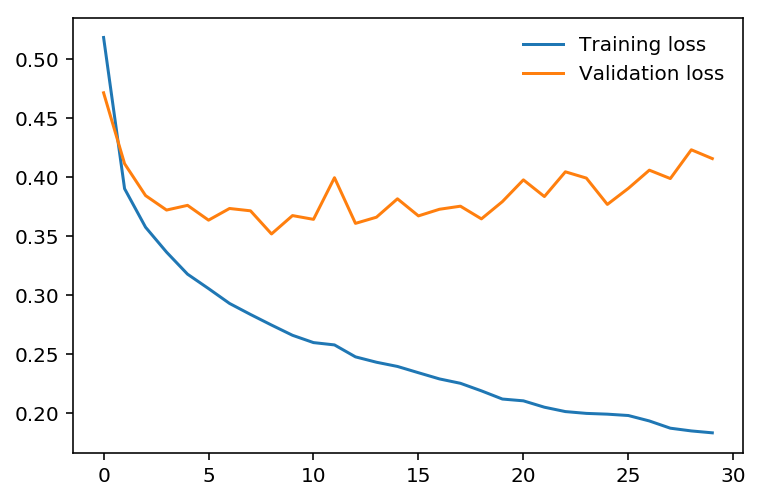

In [93]:
#visualize train losses and test losses for each epoch
plt.plot(train_losses, label = 'Training loss',)
plt.plot(test_losses, label = 'Validation loss')
plt.legend(frameon = False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [114]:
## TODO: Define your model with dropout added
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_input, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0],n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1],n_hidden[2])
        self.fc4 = nn.Linear(n_hidden[2],n_output)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [108]:
n_input = 784
n_hidden = [256,128,64]
n_output = 10

In [129]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.003)

#create 3 list place holder for losses and accuracy for all epochs
training_losses, test_losses, Accuracy_epoch = [], [], []
epochs = 30

for e in range(epochs): #loop through epochs
    running_train_losses= 0 #starting value for train losses
    for images, labels in trainloader:
        optimizer.zero_grad() #clear gradient before looping through each batch
        log_ps = model(images)
        #calculate losses for each batch 
        loss = criterion(log_ps, labels)
        #backprop loss
        loss.backward()
        #optimizer step to update weight
        optimizer.step()
        #calculate train losses for all batches in the epoch 
        running_train_losses += loss.item()
    else: #after all the batches in trainloader has been trained for 1 epoch, use model in validation test
        #turn off gradients to speed up processes
        running_test_loss = 0
        running_accuracy = 0 
        with torch.no_grad():
            model.eval() #set model to evaluation mode to stop dropout
            for images, labels in testloader:
                output = model(images)
                #calculate accuracy for each batch
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1,dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)) 
                running_accuracy += accuracy.item()
                #calculate running losses, accuracy 
                loss = criterion(output,labels)
                running_test_loss += loss.item()
            
            training_losses.append(running_train_losses/len(trainloader))
            test_losses.append(running_test_loss/len(testloader))
            Accuracy_epoch.append(running_accuracy/len(testloader))
            print(running_accuracy/len(testloader)*100)
            # set model back to train mode before going to another epoch
            model.train()
          

83.11106687898089
84.06648089171973
85.20103503184714
85.49960191082803
85.23089171974523
85.35031847133759
85.72850318471338
85.84792993630573
85.67874203821655
86.27587579617835
86.76353503184714
86.58439490445859
86.33558917197452
85.97730891719745
86.89291401273886
86.98248407643312
86.70382165605095
86.9625796178344
86.5047770700637
86.42515923566879
87.03224522292994
86.79339171974523
86.81329617834395
87.47014331210191
87.609474522293
87.2312898089172
87.13176751592357
87.281050955414
87.90804140127389
87.92794585987261


In [130]:
  
print('Traning losses')
print(training_losses)
print('Test losses')
print(test_losses)
print('Accuracy')
print(Accuracy_epoch)

Traning losses
[0.6067637465020487, 0.48462120171930234, 0.4543416810823656, 0.4351036872055485, 0.4225041824204327, 0.4100850102966274, 0.4036573310301248, 0.40157315209666805, 0.39061468010391, 0.3882356609013289, 0.3826613722484249, 0.3810389555339366, 0.374532446797405, 0.3770594314487377, 0.37372902361378235, 0.36925175289577766, 0.3651161315694038, 0.3624212254942861, 0.35776114935623304, 0.3493023657881375, 0.3662761613281805, 0.35472396800099915, 0.35815797144892625, 0.3454465404756542, 0.3492889174981031, 0.34502669616834697, 0.3432220714861777, 0.35257587627148324, 0.3399686809462398, 0.33607699890444276]
Test losses
[0.47617173489112, 0.44189628854299046, 0.4108226786658263, 0.4014347796417346, 0.4026476659212902, 0.39973956598028254, 0.4056538063439594, 0.40361612598607494, 0.3958535291207064, 0.4177908438975644, 0.381992520800062, 0.3803102136797206, 0.3949805274131192, 0.3877497044908013, 0.38345236255294957, 0.37264956486452916, 0.4040786581244438, 0.3940876834331804, 0.

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

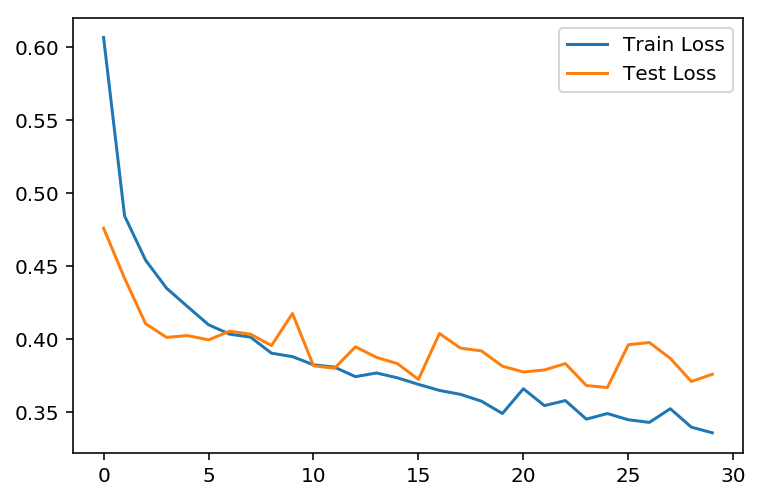

In [131]:
plt.plot(training_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()

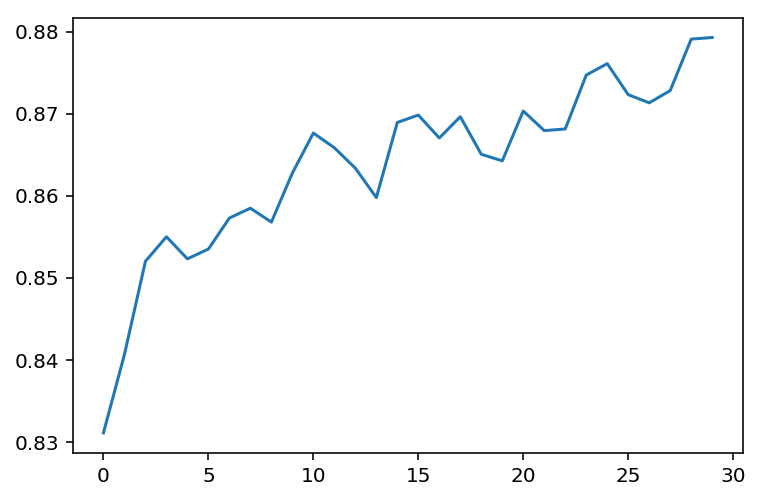

In [132]:
plt.plot(Accuracy_epoch,label = 'Accuracy')

In [145]:
#check model parameters after training
print(model.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


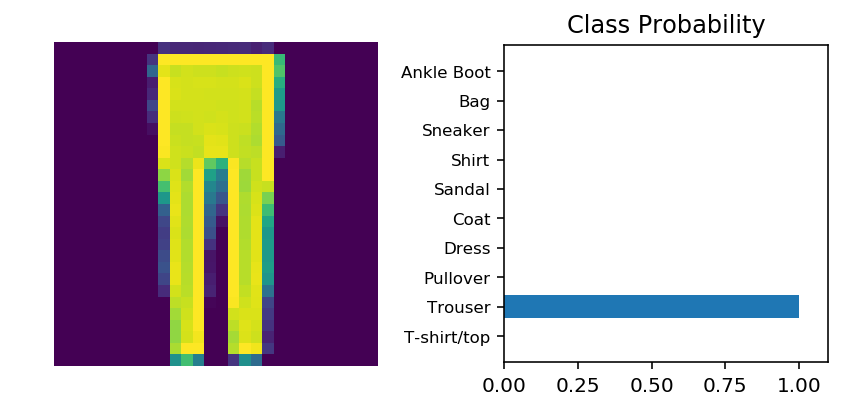

In [142]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.